# Procesamiento de Videos con MediaPipe

Este cuaderno procesa videos de movimientos corporales y extrae datos de seguimiento de poses usando MediaPipe.

## Estructura de datos:

- **Entrada**: `data/raw/{nombre_accion}/` - Videos de diferentes acciones

- **Salida**: `data/processed/{nombre_accion}/` - Archivos JSON y CSV con datos de poses

In [2]:
# Instalación de dependencias necesarias
!pip install mediapipe opencv-python pandas numpy matplotlib
!pip install google-colab-drive

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/51.0 MB ? eta -:--:--
   - -------------------------------------- 2.4/51.0 MB 13.4 MB/s eta 0:00:04
   --- ------------------------------------ 4.7/51.0 MB 13.0 MB/s eta 0:00:04
   ---- ----------------------------------- 6.0/51.0 MB 10.2 MB/s eta 0:00:05
   ----- ---------------------------------- 7.1/51.0 MB 8.7 MB/s eta 0:00:06
   ------ --------------------------------- 8.7/51.0 MB 8.5 MB/s eta 0:00:05
   ------- -------------------------------- 10.0/51.0 MB 8.1 MB/s eta 0:00:06
   --------- ------------------------------ 12.1/51.0 MB 8.3 MB/s eta 0:00:05
   ---------- ----------------------------- 13.6/51.0 MB 8.3 MB/s eta 0:00:05
   ------------ --------------------------- 15.7/51.0 MB 8.5 MB/s eta 0:00:05
   ------------- -------------------------- 17.8/51.0 MB 8.6 MB/s eta 0:00:04
   -------------- ------------------------- 18.9/51.0 MB 8.6 MB/s eta 0:00

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.67.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement google-colab-drive (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for google-colab-drive


In [2]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Configuración de MediaPipe
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [3]:
# Definir rutas del proyecto (ajusta según tu ubicación en Drive)
PROJECT_PATH = 'C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model'  # Ajusta esta ruta
RAW_DATA_PATH = f'{PROJECT_PATH}/data/raw'
PROCESSED_DATA_PATH = f'{PROJECT_PATH}/data/processed'

# Crear directorio processed si no existe
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)

print(f"Ruta del proyecto: {PROJECT_PATH}\\")
print(f"Datos raw: {RAW_DATA_PATH}\\")
print(f"Datos procesados: {PROCESSED_DATA_PATH}\\")

Ruta del proyecto: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model\
Datos raw: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/raw\
Datos procesados: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\


In [4]:
class PoseExtractor:
    def __init__(self, min_detection_confidence=0.5, min_tracking_confidence=0.5):
        self.pose = mp_pose.Pose(
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=min_tracking_confidence
        )
        self.pose_landmarks = []

    def extract_pose_landmarks(self, image):
        """Extrae landmarks de pose de una imagen""",
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.pose.process(image_rgb)

        if results.pose_landmarks:
            landmarks = []
            for landmark in results.pose_landmarks.landmark:
                landmarks.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
            return landmarks, results
        else:
            # Si no se detectan poses, retornar None o landmarks vacíos
            return [0.0] * (33 * 4), results  # 33 landmarks × 4 valores (x,y,z,visibility)

    def process_video(self, video_path, output_prefix):
        """Procesa un video completo y extrae poses de todos los frames"""
        cap = cv2.VideoCapture(str(video_path))

        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None, None

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Procesando: {video_path.name}")
        print(f"FPS: {fps}, Total frames: {total_frames}")

        frames_data = []
        frame_number = 0

        # Crear barra de progreso
        with tqdm(total=total_frames, desc="Procesando frames") as pbar:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                # Extraer landmarks
                landmarks, results = self.extract_pose_landmarks(frame)

                # Calcular timestamp
                timestamp = frame_number / fps

                frame_data = {
                 'frame': frame_number,
                    'timestamp': timestamp,
                    'landmarks': landmarks,
                    'pose_detected': results.pose_landmarks is not None
                }

                frames_data.append(frame_data)
                frame_number += 1
                pbar.update(1)

        cap.release()

        # Convertir a DataFrame para CSV
        df_data = []
        for frame_data in frames_data:
            row = {
                'frame': frame_data['frame'],
                'timestamp': frame_data['timestamp'],
                'pose_detected': frame_data['pose_detected']
            }

            # Agregar landmarks como columnas separadas
            landmarks = frame_data['landmarks']
            for i in range(0, len(landmarks), 4):
                landmark_idx = i // 4
                row[f'landmark_{landmark_idx}_x'] = landmarks[i]
                row[f'landmark_{landmark_idx}_y'] = landmarks[i + 1]
                row[f'landmark_{landmark_idx}_z'] = landmarks[i + 2]
                row[f'landmark_{landmark_idx}_visibility'] = landmarks[i + 3]

            df_data.append(row)

        df = pd.DataFrame(df_data)

        return frames_data, df

    def save_data(self, frames_data, df, output_dir, video_name):
        """Guarda los datos en formato JSON y CSV"""
        os.makedirs(output_dir, exist_ok=True)

        # Guardar JSON\n",
        json_path = os.path.join(output_dir, f"{video_name}_poses.json")
        with open(json_path, 'w') as f:
            json.dump(frames_data, f, indent=2)

        # Guardar CSV
        csv_path = os.path.join(output_dir, f"{video_name}_poses.csv")
        df.to_csv(csv_path, index=False)

        print(f"Datos guardados en:")
        print(f"  JSON: {json_path}")
        print(f"  CSV: {csv_path}")

        return json_path, csv_path

In [5]:
def process_all_videos(raw_data_path, processed_data_path):
    """Procesa todos los videos en las carpetas de acciones"""

    # Extensiones de video soportadas
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv']

    # Inicializar extractor de poses
    pose_extractor = PoseExtractor()

    # Obtener todas las carpetas de acciones\n",
    action_folders = [d for d in os.listdir(raw_data_path)
                     if os.path.isdir(os.path.join(raw_data_path, d))]

    print(f"Acciones encontradas: {action_folders}")

    processing_summary = {}

    for action in action_folders:
        print(f"\n{'='*50}")
        print(f"Procesando acción: {action}")
        print(f"{'='*50}")

        action_raw_path = os.path.join(raw_data_path, action)
        action_processed_path = os.path.join(processed_data_path, action)

        # Crear directorio de salida para esta acción
        os.makedirs(action_processed_path, exist_ok=True)

        # Encontrar todos los videos en esta carpeta de acción
        video_files = []
        for file in os.listdir(action_raw_path):
            if any(file.lower().endswith(ext) for ext in video_extensions):
                video_files.append(file)

        print(f"Videos encontrados: {len(video_files)}")

        action_results = []

        for video_file in video_files:
            video_path = Path(os.path.join(action_raw_path, video_file))
            video_name = video_path.stem  # Nombre sin extensión

            print(f"\nProcesando: {video_file}")

            try:
                # Procesar video
                frames_data, df = pose_extractor.process_video(video_path, video_name)

                if frames_data is not None:
                    # Guardar datos
                    json_path, csv_path = pose_extractor.save_data(
                        frames_data, df, action_processed_path, video_name
                    )

                    # Estadísticas
                    total_frames = len(frames_data)
                    frames_with_pose = sum(1 for frame in frames_data if frame['pose_detected'])
                    detection_rate = (frames_with_pose / total_frames) * 100 if total_frames > 0 else 0

                    result = {
                        'video_file': video_file,
                        'total_frames': total_frames,
                        'frames_with_pose': frames_with_pose,
                        'detection_rate': detection_rate,
                        'json_path': json_path,
                        'csv_path': csv_path,
                        'status': 'success'
                    }

                    print(f"✓ Procesado exitosamente")
                    print(f"  Frames totales: {total_frames}")
                    print(f"  Frames con pose: {frames_with_pose}")
                    print(f"  Tasa de detección: {detection_rate:.1f}%")

                else:
                    result = {
                        'video_file': video_file,
                        'status': 'error',
                        'error': 'No se pudo procesar el video'
                    }
                    print(f"✗ Error al procesar el video")

            except Exception as e:
                result = {
                    'video_file': video_file,
                    'status': 'error',
                    'error': str(e)
                }
                print(f"✗ Error: {e}")

            action_results.append(result)

        processing_summary[action] = action_results

    return processing_summary

In [6]:
# Ejecutar el procesamiento\n",
print("Iniciando procesamiento de videos...")
print(f"Buscando videos en: {RAW_DATA_PATH}")
print(f"Guardando resultados en: {PROCESSED_DATA_PATH}")

start_time = time.time()
summary = process_all_videos(RAW_DATA_PATH, PROCESSED_DATA_PATH)
end_time = time.time()

print(f"\n{'='*60}")
print("RESUMEN DE PROCESAMIENTO")
print(f"{'='*60}")
print(f"Tiempo total: {end_time - start_time:.2f} segundos")

total_videos = 0
total_successful = 0

for action, results in summary.items():
    successful = sum(1 for r in results if r['status'] == 'success')
    total = len(results)

    total_videos += total
    total_successful += successful

    print(f"\n{action}:")
    print(f"  Videos procesados: {successful}/{total}")

    if successful > 0:
        avg_detection = np.mean([r.get('detection_rate', 0) for r in results if r['status'] == 'success'])
        print(f"  Tasa promedio de detección: {avg_detection:.1f}%")

    print(f"\nTotal general: {total_successful}/{total_videos} videos procesados exitosamente")

Iniciando procesamiento de videos...
Buscando videos en: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/raw
Guardando resultados en: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed
Acciones encontradas: ['devolverse', 'ir al frente', 'parar', 'sentar', 'voltear']

Procesando acción: devolverse
Videos encontrados: 7

Procesando: devolverse 1.mp4
Procesando: devolverse 1.mp4
FPS: 30.0, Total frames: 153


Procesando frames: 100%|██████████| 153/153 [00:06<00:00, 23.79it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 1_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 1_poses.csv
✓ Procesado exitosamente
  Frames totales: 153
  Frames con pose: 153
  Tasa de detección: 100.0%

Procesando: devolverse 2.mp4
Procesando: devolverse 2.mp4
FPS: 30.0, Total frames: 106


Procesando frames: 100%|██████████| 106/106 [00:04<00:00, 25.75it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 2_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 2_poses.csv
✓ Procesado exitosamente
  Frames totales: 106
  Frames con pose: 88
  Tasa de detección: 83.0%

Procesando: devolverse 3.mp4
Procesando: devolverse 3.mp4
FPS: 30.0, Total frames: 88


Procesando frames: 100%|██████████| 88/88 [00:03<00:00, 25.13it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 3_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 3_poses.csv
✓ Procesado exitosamente
  Frames totales: 88
  Frames con pose: 71
  Tasa de detección: 80.7%

Procesando: devolverse 4.mp4
Procesando: devolverse 4.mp4
FPS: 30.0, Total frames: 82


Procesando frames: 100%|██████████| 82/82 [00:03<00:00, 26.36it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 4_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 4_poses.csv
✓ Procesado exitosamente
  Frames totales: 82
  Frames con pose: 81
  Tasa de detección: 98.8%

Procesando: devolverse 5.mp4
Procesando: devolverse 5.mp4
FPS: 30.0, Total frames: 63


Procesando frames: 100%|██████████| 63/63 [00:02<00:00, 25.44it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 5_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 5_poses.csv
✓ Procesado exitosamente
  Frames totales: 63
  Frames con pose: 60
  Tasa de detección: 95.2%

Procesando: devolverse 6.mp4
Procesando: devolverse 6.mp4
FPS: 30.0, Total frames: 64


Procesando frames: 100%|██████████| 64/64 [00:02<00:00, 26.03it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 6_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 6_poses.csv
✓ Procesado exitosamente
  Frames totales: 64
  Frames con pose: 55
  Tasa de detección: 85.9%

Procesando: devolverse 7.mp4
Procesando: devolverse 7.mp4
FPS: 30.0, Total frames: 91


Procesando frames: 100%|██████████| 91/91 [00:03<00:00, 25.61it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 7_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\devolverse\devolverse 7_poses.csv
✓ Procesado exitosamente
  Frames totales: 91
  Frames con pose: 88
  Tasa de detección: 96.7%

Procesando acción: ir al frente
Videos encontrados: 8

Procesando: al frente 4.mp4
Procesando: al frente 4.mp4
FPS: 30.0, Total frames: 82


Procesando frames: 100%|██████████| 82/82 [00:03<00:00, 26.03it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 4_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 4_poses.csv
✓ Procesado exitosamente
  Frames totales: 82
  Frames con pose: 82
  Tasa de detección: 100.0%

Procesando: al frente 5.mp4
Procesando: al frente 5.mp4
FPS: 30.0, Total frames: 107


Procesando frames: 100%|██████████| 107/107 [00:04<00:00, 25.49it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 5_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 5_poses.csv
✓ Procesado exitosamente
  Frames totales: 107
  Frames con pose: 105
  Tasa de detección: 98.1%

Procesando: al frente 6.mp4
Procesando: al frente 6.mp4
FPS: 30.0, Total frames: 115


Procesando frames: 100%|██████████| 115/115 [00:04<00:00, 25.11it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 6_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 6_poses.csv
✓ Procesado exitosamente
  Frames totales: 115
  Frames con pose: 112
  Tasa de detección: 97.4%

Procesando: al frente 7.mp4
Procesando: al frente 7.mp4
FPS: 30.0, Total frames: 93


Procesando frames: 100%|██████████| 93/93 [00:03<00:00, 26.09it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 7_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 7_poses.csv
✓ Procesado exitosamente
  Frames totales: 93
  Frames con pose: 87
  Tasa de detección: 93.5%

Procesando: al frente 8.mp4
Procesando: al frente 8.mp4
FPS: 30.0, Total frames: 128


Procesando frames: 100%|██████████| 128/128 [00:04<00:00, 26.36it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 8_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\al frente 8_poses.csv
✓ Procesado exitosamente
  Frames totales: 128
  Frames con pose: 125
  Tasa de detección: 97.7%

Procesando: frente 1.mp4
Procesando: frente 1.mp4
FPS: 30.0, Total frames: 133


Procesando frames: 100%|██████████| 133/133 [00:05<00:00, 25.77it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\frente 1_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\frente 1_poses.csv
✓ Procesado exitosamente
  Frames totales: 133
  Frames con pose: 116
  Tasa de detección: 87.2%

Procesando: frente 2.mp4
Procesando: frente 2.mp4
FPS: 30.0, Total frames: 91


Procesando frames: 100%|██████████| 91/91 [00:03<00:00, 26.07it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\frente 2_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\frente 2_poses.csv
✓ Procesado exitosamente
  Frames totales: 91
  Frames con pose: 84
  Tasa de detección: 92.3%

Procesando: frente 3.mp4
Procesando: frente 3.mp4
FPS: 30.0, Total frames: 91


Procesando frames: 100%|██████████| 91/91 [00:03<00:00, 25.67it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\frente 3_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\ir al frente\frente 3_poses.csv
✓ Procesado exitosamente
  Frames totales: 91
  Frames con pose: 91
  Tasa de detección: 100.0%

Procesando acción: parar
Videos encontrados: 12

Procesando: pararse 1.mp4
Procesando: pararse 1.mp4
FPS: 30.0, Total frames: 82


Procesando frames: 100%|██████████| 82/82 [00:03<00:00, 25.45it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 1_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 1_poses.csv
✓ Procesado exitosamente
  Frames totales: 82
  Frames con pose: 81
  Tasa de detección: 98.8%

Procesando: pararse 10.mp4
Procesando: pararse 10.mp4
FPS: 30.0, Total frames: 61


Procesando frames: 100%|██████████| 61/61 [00:02<00:00, 26.52it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 10_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 10_poses.csv
✓ Procesado exitosamente
  Frames totales: 61
  Frames con pose: 61
  Tasa de detección: 100.0%

Procesando: pararse 11.mp4
Procesando: pararse 11.mp4
FPS: 30.0, Total frames: 62


Procesando frames: 100%|██████████| 62/62 [00:02<00:00, 25.25it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 11_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 11_poses.csv
✓ Procesado exitosamente
  Frames totales: 62
  Frames con pose: 62
  Tasa de detección: 100.0%

Procesando: pararse 12.mp4
Procesando: pararse 12.mp4
FPS: 30.0, Total frames: 76


Procesando frames: 100%|██████████| 76/76 [00:03<00:00, 25.15it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 12_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 12_poses.csv
✓ Procesado exitosamente
  Frames totales: 76
  Frames con pose: 76
  Tasa de detección: 100.0%

Procesando: pararse 2.mp4
Procesando: pararse 2.mp4
FPS: 30.0, Total frames: 72


Procesando frames: 100%|██████████| 72/72 [00:04<00:00, 17.70it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 2_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 2_poses.csv
✓ Procesado exitosamente
  Frames totales: 72
  Frames con pose: 72
  Tasa de detección: 100.0%

Procesando: pararse 3.mp4
Procesando: pararse 3.mp4
FPS: 30.0, Total frames: 113


Procesando frames: 100%|██████████| 113/113 [00:05<00:00, 21.60it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 3_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 3_poses.csv
✓ Procesado exitosamente
  Frames totales: 113
  Frames con pose: 112
  Tasa de detección: 99.1%

Procesando: pararse 4.mp4
Procesando: pararse 4.mp4
FPS: 30.0, Total frames: 95


Procesando frames: 100%|██████████| 95/95 [00:04<00:00, 20.78it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 4_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 4_poses.csv
✓ Procesado exitosamente
  Frames totales: 95
  Frames con pose: 94
  Tasa de detección: 98.9%

Procesando: pararse 5.mp4
Procesando: pararse 5.mp4
FPS: 30.0, Total frames: 115


Procesando frames: 100%|██████████| 115/115 [00:05<00:00, 21.49it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 5_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 5_poses.csv
✓ Procesado exitosamente
  Frames totales: 115
  Frames con pose: 115
  Tasa de detección: 100.0%

Procesando: pararse 6.mp4
Procesando: pararse 6.mp4
FPS: 30.0, Total frames: 80


Procesando frames: 100%|██████████| 80/80 [00:03<00:00, 21.36it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 6_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 6_poses.csv
✓ Procesado exitosamente
  Frames totales: 80
  Frames con pose: 80
  Tasa de detección: 100.0%

Procesando: pararse 7.mp4
Procesando: pararse 7.mp4
FPS: 30.0, Total frames: 89


Procesando frames: 100%|██████████| 89/89 [00:04<00:00, 21.23it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 7_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 7_poses.csv
✓ Procesado exitosamente
  Frames totales: 89
  Frames con pose: 89
  Tasa de detección: 100.0%

Procesando: pararse 8.mp4
Procesando: pararse 8.mp4
FPS: 30.0, Total frames: 87


Procesando frames: 100%|██████████| 87/87 [00:03<00:00, 23.09it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 8_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 8_poses.csv
✓ Procesado exitosamente
  Frames totales: 87
  Frames con pose: 87
  Tasa de detección: 100.0%

Procesando: pararse 9.mp4
Procesando: pararse 9.mp4
FPS: 30.0, Total frames: 73


Procesando frames: 100%|██████████| 73/73 [00:03<00:00, 23.16it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 9_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\parar\pararse 9_poses.csv
✓ Procesado exitosamente
  Frames totales: 73
  Frames con pose: 73
  Tasa de detección: 100.0%

Procesando acción: sentar
Videos encontrados: 15

Procesando: sentar 1.mp4
Procesando: sentar 1.mp4
FPS: 30.0, Total frames: 123


Procesando frames: 100%|██████████| 123/123 [00:05<00:00, 21.39it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 1_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 1_poses.csv
✓ Procesado exitosamente
  Frames totales: 123
  Frames con pose: 122
  Tasa de detección: 99.2%

Procesando: sentar 10.mp4
Procesando: sentar 10.mp4
FPS: 30.0, Total frames: 74


Procesando frames: 100%|██████████| 74/74 [00:03<00:00, 22.72it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 10_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 10_poses.csv
✓ Procesado exitosamente
  Frames totales: 74
  Frames con pose: 74
  Tasa de detección: 100.0%

Procesando: sentar 11.mp4
Procesando: sentar 11.mp4
FPS: 30.0, Total frames: 102


Procesando frames: 100%|██████████| 102/102 [00:04<00:00, 22.35it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 11_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 11_poses.csv
✓ Procesado exitosamente
  Frames totales: 102
  Frames con pose: 102
  Tasa de detección: 100.0%

Procesando: sentar 12.mp4
Procesando: sentar 12.mp4
FPS: 30.0, Total frames: 77


Procesando frames: 100%|██████████| 77/77 [00:03<00:00, 23.72it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 12_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 12_poses.csv
✓ Procesado exitosamente
  Frames totales: 77
  Frames con pose: 76
  Tasa de detección: 98.7%

Procesando: sentar 13.mp4
Procesando: sentar 13.mp4
FPS: 30.0, Total frames: 73


Procesando frames: 100%|██████████| 73/73 [00:03<00:00, 18.82it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 13_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 13_poses.csv
✓ Procesado exitosamente
  Frames totales: 73
  Frames con pose: 72
  Tasa de detección: 98.6%

Procesando: sentar 14.mp4
Procesando: sentar 14.mp4
FPS: 30.0, Total frames: 83


Procesando frames: 100%|██████████| 83/83 [00:03<00:00, 22.14it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 14_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 14_poses.csv
✓ Procesado exitosamente
  Frames totales: 83
  Frames con pose: 83
  Tasa de detección: 100.0%

Procesando: sentar 15.mp4
Procesando: sentar 15.mp4
FPS: 30.0, Total frames: 106


Procesando frames: 100%|██████████| 106/106 [00:04<00:00, 22.53it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 15_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 15_poses.csv
✓ Procesado exitosamente
  Frames totales: 106
  Frames con pose: 105
  Tasa de detección: 99.1%

Procesando: sentar 2.mp4
Procesando: sentar 2.mp4
FPS: 30.0, Total frames: 76


Procesando frames: 100%|██████████| 76/76 [00:03<00:00, 21.82it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 2_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 2_poses.csv
✓ Procesado exitosamente
  Frames totales: 76
  Frames con pose: 76
  Tasa de detección: 100.0%

Procesando: sentar 3.mp4
Procesando: sentar 3.mp4
FPS: 30.0, Total frames: 170


Procesando frames: 100%|██████████| 170/170 [00:07<00:00, 22.08it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 3_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 3_poses.csv
✓ Procesado exitosamente
  Frames totales: 170
  Frames con pose: 169
  Tasa de detección: 99.4%

Procesando: sentar 4.mp4
Procesando: sentar 4.mp4
FPS: 30.0, Total frames: 80


Procesando frames: 100%|██████████| 80/80 [00:03<00:00, 22.46it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 4_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 4_poses.csv
✓ Procesado exitosamente
  Frames totales: 80
  Frames con pose: 80
  Tasa de detección: 100.0%

Procesando: sentar 5.mp4
Procesando: sentar 5.mp4
FPS: 30.0, Total frames: 159


Procesando frames: 100%|██████████| 159/159 [00:07<00:00, 21.44it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 5_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 5_poses.csv
✓ Procesado exitosamente
  Frames totales: 159
  Frames con pose: 156
  Tasa de detección: 98.1%

Procesando: sentar 6.mp4
Procesando: sentar 6.mp4
FPS: 30.0, Total frames: 94


Procesando frames: 100%|██████████| 94/94 [00:04<00:00, 21.88it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 6_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 6_poses.csv
✓ Procesado exitosamente
  Frames totales: 94
  Frames con pose: 93
  Tasa de detección: 98.9%

Procesando: sentar 7.mp4
Procesando: sentar 7.mp4
FPS: 30.0, Total frames: 59


Procesando frames: 100%|██████████| 59/59 [00:02<00:00, 22.63it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 7_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 7_poses.csv
✓ Procesado exitosamente
  Frames totales: 59
  Frames con pose: 58
  Tasa de detección: 98.3%

Procesando: sentar 8.mp4
Procesando: sentar 8.mp4
FPS: 30.0, Total frames: 149


Procesando frames: 100%|██████████| 149/149 [00:07<00:00, 21.14it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 8_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 8_poses.csv
✓ Procesado exitosamente
  Frames totales: 149
  Frames con pose: 148
  Tasa de detección: 99.3%

Procesando: sentar 9.mp4
Procesando: sentar 9.mp4
FPS: 30.0, Total frames: 104


Procesando frames: 100%|██████████| 104/104 [00:04<00:00, 21.42it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 9_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\sentar\sentar 9_poses.csv
✓ Procesado exitosamente
  Frames totales: 104
  Frames con pose: 103
  Tasa de detección: 99.0%

Procesando acción: voltear
Videos encontrados: 21

Procesando: voltear 1.mp4
Procesando: voltear 1.mp4
FPS: 30.0, Total frames: 99


Procesando frames: 100%|██████████| 99/99 [00:05<00:00, 19.32it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 1_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 1_poses.csv
✓ Procesado exitosamente
  Frames totales: 99
  Frames con pose: 99
  Tasa de detección: 100.0%

Procesando: voltear 10.mp4
Procesando: voltear 10.mp4
FPS: 30.0, Total frames: 96


Procesando frames: 100%|██████████| 96/96 [00:04<00:00, 21.56it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 10_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 10_poses.csv
✓ Procesado exitosamente
  Frames totales: 96
  Frames con pose: 95
  Tasa de detección: 99.0%

Procesando: voltear 11.mp4
Procesando: voltear 11.mp4
FPS: 30.0, Total frames: 95


Procesando frames: 100%|██████████| 95/95 [00:04<00:00, 22.01it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 11_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 11_poses.csv
✓ Procesado exitosamente
  Frames totales: 95
  Frames con pose: 95
  Tasa de detección: 100.0%

Procesando: voltear 12.mp4
Procesando: voltear 12.mp4
FPS: 30.0, Total frames: 45


Procesando frames: 100%|██████████| 45/45 [00:02<00:00, 20.43it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 12_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 12_poses.csv
✓ Procesado exitosamente
  Frames totales: 45
  Frames con pose: 45
  Tasa de detección: 100.0%

Procesando: voltear 13.mp4
Procesando: voltear 13.mp4
FPS: 30.0, Total frames: 41


Procesando frames: 100%|██████████| 41/41 [00:01<00:00, 22.41it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 13_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 13_poses.csv
✓ Procesado exitosamente
  Frames totales: 41
  Frames con pose: 41
  Tasa de detección: 100.0%

Procesando: voltear 14.mp4
Procesando: voltear 14.mp4
FPS: 30.0, Total frames: 40


Procesando frames: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 14_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 14_poses.csv
✓ Procesado exitosamente
  Frames totales: 40
  Frames con pose: 25
  Tasa de detección: 62.5%

Procesando: voltear 15.mp4
Procesando: voltear 15.mp4
FPS: 30.0, Total frames: 47


Procesando frames: 100%|██████████| 47/47 [00:02<00:00, 18.85it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 15_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 15_poses.csv
✓ Procesado exitosamente
  Frames totales: 47
  Frames con pose: 47
  Tasa de detección: 100.0%

Procesando: voltear 16.mp4
Procesando: voltear 16.mp4
FPS: 30.0, Total frames: 55


Procesando frames: 100%|██████████| 55/55 [00:03<00:00, 16.50it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 16_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 16_poses.csv
✓ Procesado exitosamente
  Frames totales: 55
  Frames con pose: 52
  Tasa de detección: 94.5%

Procesando: voltear 17.mp4
Procesando: voltear 17.mp4
FPS: 30.0, Total frames: 45


Procesando frames: 100%|██████████| 45/45 [00:02<00:00, 19.72it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 17_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 17_poses.csv
✓ Procesado exitosamente
  Frames totales: 45
  Frames con pose: 44
  Tasa de detección: 97.8%

Procesando: voltear 18.mp4
Procesando: voltear 18.mp4
FPS: 30.0, Total frames: 44


Procesando frames: 100%|██████████| 44/44 [00:02<00:00, 19.15it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 18_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 18_poses.csv
✓ Procesado exitosamente
  Frames totales: 44
  Frames con pose: 41
  Tasa de detección: 93.2%

Procesando: voltear 19.mp4
Procesando: voltear 19.mp4
FPS: 30.0, Total frames: 55


Procesando frames: 100%|██████████| 55/55 [00:02<00:00, 23.17it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 19_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 19_poses.csv
✓ Procesado exitosamente
  Frames totales: 55
  Frames con pose: 54
  Tasa de detección: 98.2%

Procesando: voltear 2.mp4
Procesando: voltear 2.mp4
FPS: 30.0, Total frames: 109


Procesando frames: 100%|██████████| 109/109 [00:05<00:00, 20.71it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 2_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 2_poses.csv
✓ Procesado exitosamente
  Frames totales: 109
  Frames con pose: 109
  Tasa de detección: 100.0%

Procesando: voltear 20.mp4
Procesando: voltear 20.mp4
FPS: 30.0, Total frames: 61


Procesando frames: 100%|██████████| 61/61 [00:03<00:00, 19.97it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 20_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 20_poses.csv
✓ Procesado exitosamente
  Frames totales: 61
  Frames con pose: 39
  Tasa de detección: 63.9%

Procesando: voltear 21.mp4
Procesando: voltear 21.mp4
FPS: 30.0, Total frames: 64


Procesando frames: 100%|██████████| 64/64 [00:02<00:00, 23.47it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 21_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 21_poses.csv
✓ Procesado exitosamente
  Frames totales: 64
  Frames con pose: 63
  Tasa de detección: 98.4%

Procesando: voltear 3.mp4
Procesando: voltear 3.mp4
FPS: 30.0, Total frames: 101


Procesando frames: 100%|██████████| 101/101 [00:04<00:00, 20.99it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 3_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 3_poses.csv
✓ Procesado exitosamente
  Frames totales: 101
  Frames con pose: 101
  Tasa de detección: 100.0%

Procesando: voltear 4.mp4
Procesando: voltear 4.mp4
FPS: 30.0, Total frames: 136


Procesando frames: 100%|██████████| 136/136 [00:06<00:00, 22.36it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 4_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 4_poses.csv
✓ Procesado exitosamente
  Frames totales: 136
  Frames con pose: 136
  Tasa de detección: 100.0%

Procesando: voltear 5.mp4
Procesando: voltear 5.mp4
FPS: 30.0, Total frames: 109


Procesando frames: 100%|██████████| 109/109 [00:05<00:00, 21.20it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 5_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 5_poses.csv
✓ Procesado exitosamente
  Frames totales: 109
  Frames con pose: 109
  Tasa de detección: 100.0%

Procesando: voltear 6.mp4
Procesando: voltear 6.mp4
FPS: 30.0, Total frames: 102


Procesando frames: 100%|██████████| 102/102 [00:04<00:00, 22.25it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 6_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 6_poses.csv
✓ Procesado exitosamente
  Frames totales: 102
  Frames con pose: 102
  Tasa de detección: 100.0%

Procesando: voltear 7.mp4
Procesando: voltear 7.mp4
FPS: 30.0, Total frames: 81


Procesando frames: 100%|██████████| 81/81 [00:03<00:00, 21.73it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 7_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 7_poses.csv
✓ Procesado exitosamente
  Frames totales: 81
  Frames con pose: 81
  Tasa de detección: 100.0%

Procesando: voltear 8.mp4
Procesando: voltear 8.mp4
FPS: 30.0, Total frames: 115


Procesando frames: 100%|██████████| 115/115 [00:06<00:00, 18.93it/s]


Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 8_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 8_poses.csv
✓ Procesado exitosamente
  Frames totales: 115
  Frames con pose: 115
  Tasa de detección: 100.0%

Procesando: voltear 9.mp4
Procesando: voltear 9.mp4
FPS: 30.0, Total frames: 103


Procesando frames: 100%|██████████| 103/103 [00:05<00:00, 18.59it/s]

Datos guardados en:
  JSON: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 9_poses.json
  CSV: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\voltear\voltear 9_poses.csv
✓ Procesado exitosamente
  Frames totales: 103
  Frames con pose: 103
  Tasa de detección: 100.0%

RESUMEN DE PROCESAMIENTO
Tiempo total: 261.74 segundos

devolverse:
  Videos procesados: 7/7
  Tasa promedio de detección: 91.5%

Total general: 7/7 videos procesados exitosamente

ir al frente:
  Videos procesados: 8/8
  Tasa promedio de detección: 95.8%

Total general: 15/15 videos procesados exitosamente

parar:
  Videos procesados: 12/12
  Tasa promedio de detección: 99.7%

Total general: 27/27 videos procesados exitosamente

sentar:
  Videos procesados: 15/15
  Tasa promedio de detección: 99.2%

Total general: 42/42 videos procesados exitosamente

voltear:
  Videos procesados: 21/21
  Tasa promedio de detección: 95.6%

Total general: 63/63 

In [7]:
# Guardar resumen del procesamiento
summary_path = os.path.join(PROCESSED_DATA_PATH, 'processing_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Resumen guardado en: {summary_path}")

Resumen guardado en: C:/Users/13mig/Documents/Semestre 7/IA/motion-classifier-model/data/processed\processing_summary.json


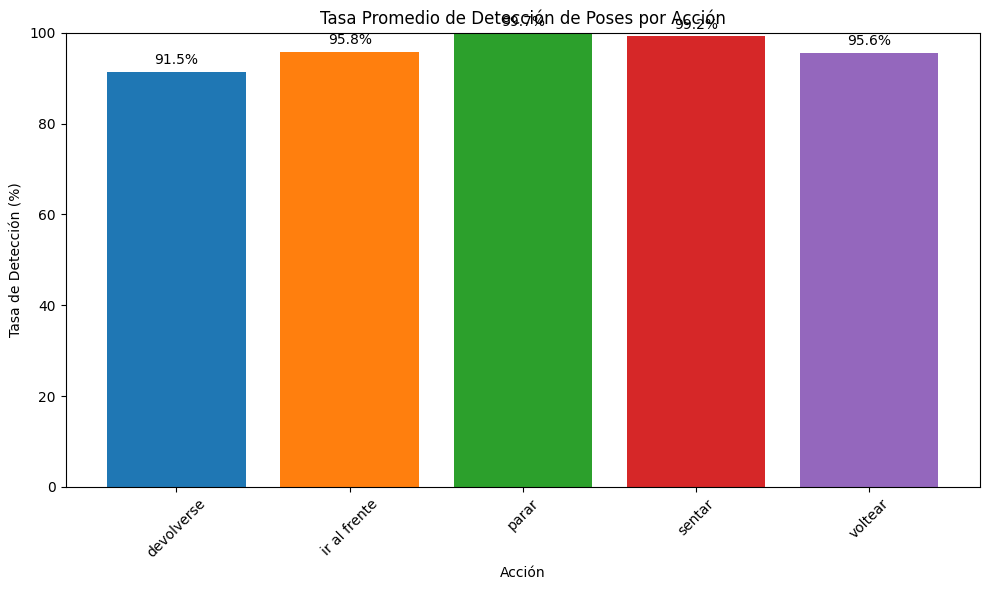

In [8]:
# Ejemplo de visualización de datos procesados
def plot_pose_detection_rates(summary):
    """Grafica las tasas de detección por acción"""
    actions = []
    avg_rates = []

    for action, results in summary.items():
        successful_results = [r for r in results if r['status'] == 'success']
        if successful_results:
            avg_rate = np.mean([r['detection_rate'] for r in successful_results])
            actions.append(action)
            avg_rates.append(avg_rate)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(actions, avg_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    plt.title('Tasa Promedio de Detección de Poses por Acción')
    plt.xlabel('Acción')
    plt.ylabel('Tasa de Detección (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)

    # Agregar valores en las barras
    for bar, rate in zip(bars, avg_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Crear visualización
plot_pose_detection_rates(summary)